In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from math import pi

import os
import sys
from pathlib import Path

import gc
from tqdm import tqdm

pd.set_option('display.max_columns', None)
rootdir = r'C:\\Users\\bened\\Documents\\UNIVERSITY\\SchoenStats\\PyTorch Working Directory\\Undergrad Stats Project\\Crime Models\\Crime Data Devon and Cornwall'

In [2]:
# collect dataframes from files
dat_2018_list = []
dat_2019_list = []
dat_2020_list = []
dat_2021_list = []
for root, dirs, files in os.walk(rootdir):
    for file in tqdm(files):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(root, file))
            if file.startswith('2018'):
                dat_2018_list.append(df)
            elif file.startswith('2019'):
                dat_2019_list.append(df)
            elif file.startswith('2020'):
                dat_2020_list.append(df)
            else:
                dat_2021_list.append(df)

100%|██████████| 36/36 [00:03<00:00, 11.24it/s]


In [3]:
def clean_dat_fn(dat_list):
    df = pd.concat(dat_list)
    df['Month'] = [int(i.split('-')[1]) for i in df['Month']]
    df['Crime type'] = df['Crime type'].astype('category')
    df_out = df[['Month', 'Longitude', 'Latitude', 'Crime type']]
    return(df_out)

In [4]:
mllc18 = clean_dat_fn(dat_2018_list)
mllc19 = clean_dat_fn(dat_2019_list)
mllc20 = clean_dat_fn(dat_2020_list)
mllc21 = clean_dat_fn(dat_2021_list)

In [5]:
data = mllc18[['Longitude', 'Latitude']].dropna()

# random sample from dataset
X = data.sample(2000).reset_index(drop=True)
X_train = torch.tensor(X.values)
X = data.sample(2000).reset_index(drop=True)
X_test = torch.tensor(X.values)

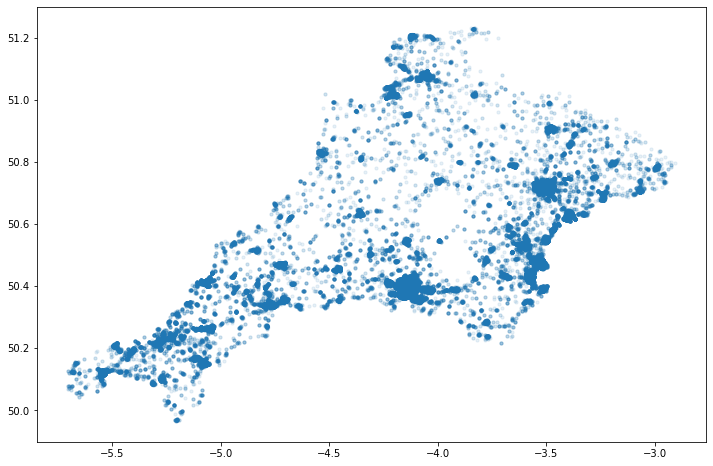

In [6]:
# plot generated dataset
k = mllc18
k = k[(k.Longitude.notna()) & (k.Longitude < -2.8) & (k.Longitude > -5.8)]
k =  k[(k.Latitude.notna()) & (k.Latitude < 51.5) & (k.Latitude > 49.5)]
long, lat = k['Longitude'], k['Latitude']

plt.figure(figsize=(12, 8))
plt.scatter(long, lat, s=10, alpha=0.1)

In [7]:
#n_samples = 2000
#noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X = np.array(X_train)
y = np.array(X_test)
# normalize
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

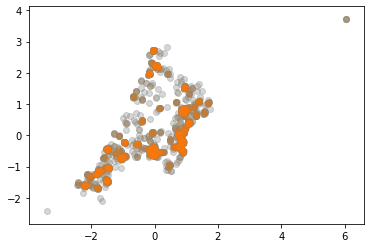

In [8]:
# replica functions for StandardScaler().fit_transform(.)
x_mu = np.mean(np.array(X_train[:,0]))
x_sd = np.std(np.array(X_train[:,0]))
y_mu = np.mean(np.array(X_train[:,1]))
y_sd = np.std(np.array(X_train[:,1]))

# test if scaling works, should produce identical plots superimposed
scale_x = (X_train[:, 0] - x_mu) / x_sd
scale_y = (X_train[:, 1] - y_mu) / y_sd
plt.scatter(scale_x, scale_y, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)

# R-NVP

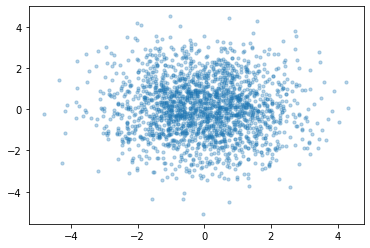

In [9]:
base_mu, base_cov = torch.zeros(2), torch.eye(2) * 2
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(2000,))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.3, s=10)
plt.show()

In [10]:
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [11]:
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

## Training Step Function

In [12]:
def train(model, epochs, batch_size, optim, scheduler):
    losses = []
    for _ in tqdm(range(epochs)):

        # get batch 
        X= X_train
        X = torch.from_numpy(StandardScaler().fit_transform(X)).float()

        optim.zero_grad()
        z, log_pz, log_jacob = model(X)
        loss = (-log_pz - log_jacob).mean()
        losses.append(loss)

        loss.backward()
        optim.step()
        scheduler.step()
    return losses

In [13]:
def view(model, losses, y):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1], alpha=0.1, s=10)
    #plt.scatter(y[:, 0], y[:, 1], alpha=0.1, s=10)
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.ylim((-2.5, 2.5))
    plt.xlim((-2.5, 2.5))
    plt.show()

    n_samples = 2000
    #X = X_train
    X = X_test
    X = torch.from_numpy(StandardScaler().fit_transform(X)).float()
    z, _, _ = model(X)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], alpha=0.2, s=20)
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()
    
    return(z, X_hat)

## Model Params

In [14]:
d = 2
k = 1

# Single Layer R_NVP

In [17]:
model = R_NVP(d, k, hidden=512)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
n_samples = 512
# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

100%|██████████| 1000/1000 [01:06<00:00, 14.97it/s]


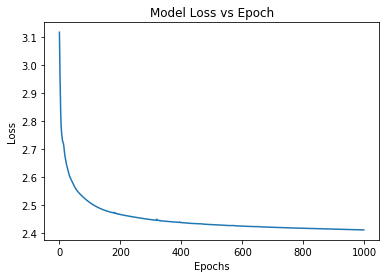

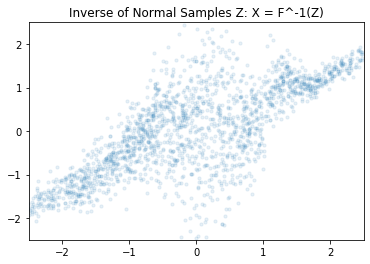

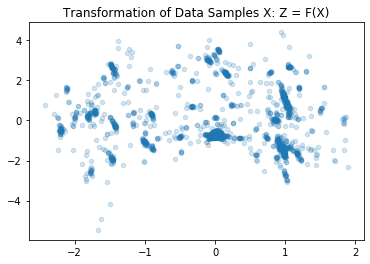

In [18]:
z_res, x_hat_res = view(model, losses, y)

# 3 Layer R_NVP

In [28]:
model = stacked_NVP(d, k, hidden=512, n=3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

100%|██████████| 1000/1000 [02:37<00:00,  6.37it/s]


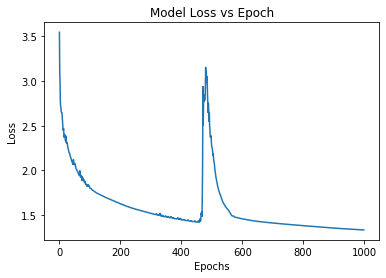

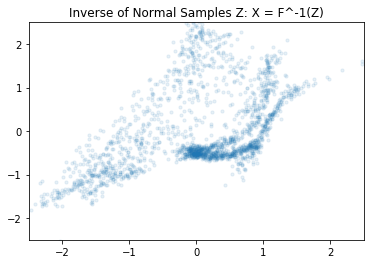

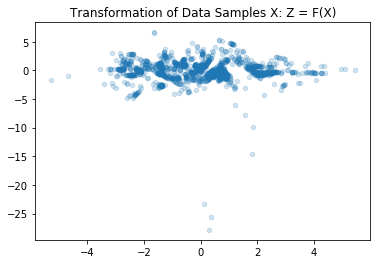

In [29]:
z_res, x_hat_res = view(model, losses, y)

# 5 Layer R_NVP

In [30]:
model = stacked_NVP(d, k, hidden=512, n=5)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


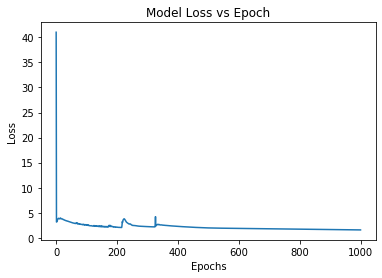

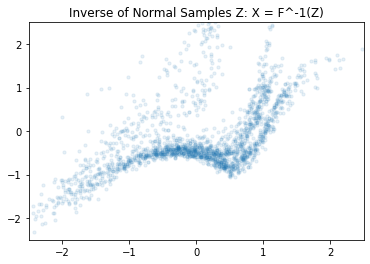

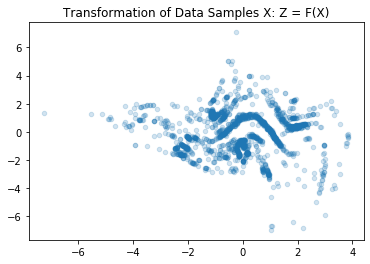

In [31]:
z_res, x_hat_res = view(model, losses, y)

# 10 Layer R_NVP

In [20]:
model = stacked_NVP(d, k, hidden=512, n=10)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 2000, n_samples, optim, scheduler)

100%|██████████| 2000/2000 [13:46<00:00,  2.42it/s]


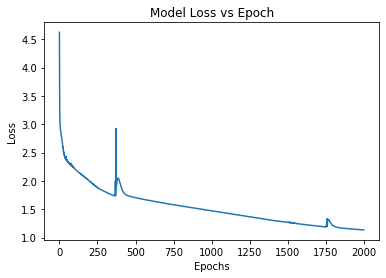

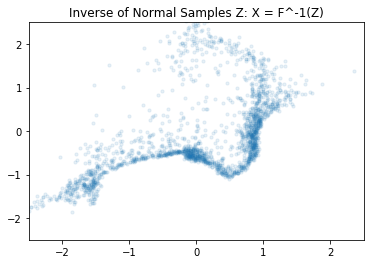

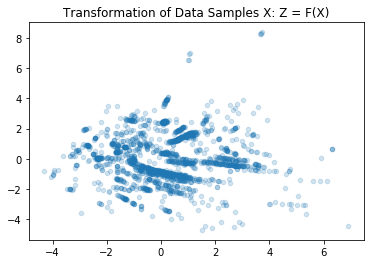

In [21]:
z_res, x_hat_res = view(model, losses, y)

# 15 Layer R_NVP

In [30]:
model = stacked_NVP(d, k, hidden=512, n=15)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

100%|██████████| 1000/1000 [08:56<00:00,  1.86it/s]


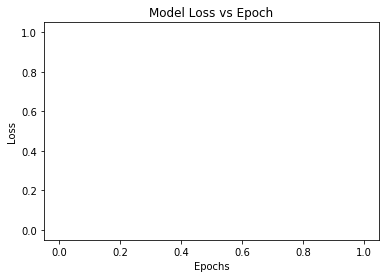

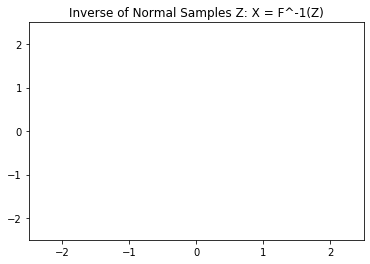

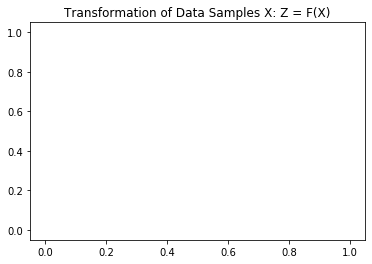

In [31]:
z_res, x_hat_res = view(model, losses, y)

## 20 layer R_NVP

In [22]:
model = stacked_NVP(d, k, hidden=512, n=20)
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 2000, n_samples, optim, scheduler)

100%|██████████| 2000/2000 [21:37<00:00,  1.54it/s]


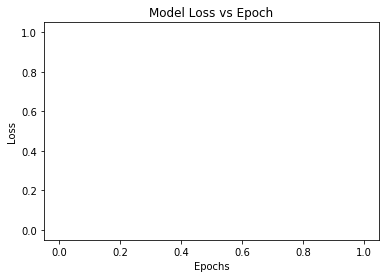

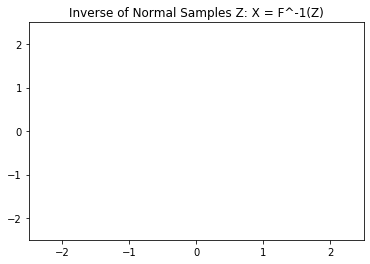

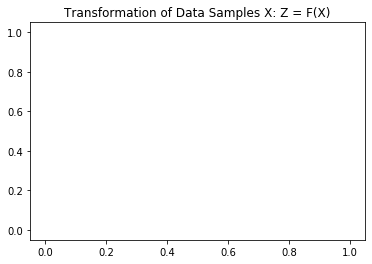

In [23]:
z_res, x_hat_res = view(model, losses, y)

# Model Tests; generate Test Data

In [17]:
def gen_sine_wave_sample(n=2000, s=1, amp=1, wl=1,
                  ns_mean=0, ns_var=1, lim_y=True, lim_x=True, x_type='rand',
                  x_range=(0,1), y_range=(0,1), set_input=None,
                  r_rad=0, swap_axis=False, formula=2):
    # n - number of points to generate
    # s - slope gradient of wave
    # amp - amplitude of wave
    # wl - wavelength equivalent parameter
    # ns_mean, ns_var - noise mean and variance
    
    # set how the domain is generated
    if x_type == 'rand':
        x = np.random.rand(n)
    elif x_type == 'lin' :
        x = np.linspace(0, 1, n, endpoint=True)
    elif x_type == 'self' :
        x = set_input
    
    #set x limits
    if lim_x:
        x = np.interp(x, (x.min(), x.max()), x_range)
        
    epsilon = ns_mean + ns_var * np.random.randn(n)
    # apply to formula [y = s*x + mag*sin(wl*x)]
    if formula==0:
        y = s*x + amp*x*np.sin(wl*x) + epsilon
    elif formula==1:
        y = s*x + amp*x*np.sin(wl*x) + epsilon*x
    elif formula==2:
        y = s*x + amp*x*np.sin(wl*x)
    else:
        y = s*x + amp*np.sin(wl*x) + epsilon
    # create rotation matrix
    rM = np.array((np.cos(r_rad), -np.sin(r_rad), np.sin(r_rad), np.cos(r_rad))).reshape((-1, 2))
    t = np.array((x, y))
    
    # set y limits
    if lim_y:        
        t = t[:, t[1] < y_range[1]]
        t = t[:, t[1] > y_range[0]]
    
    # swap x and y axis
    if (swap_axis==True):
        t = t[[1, 0], :]
    
    # rotation matrix
    output = np.matmul(rM, t)
    
    # note that (no. of output) <= n
    return(output)
    

In [18]:
# scaling x_hat_res to return to original
pred_scaled_x = (x_hat_res[:, 0] * x_sd) + x_mu
pred_scaled_y = (x_hat_res[:, 1] * y_sd) + y_mu

# once scaled, we can input the data into the actual toy data generator
t = gen_sine_wave_sample(s=0.9, amp=0.25, wl=13, formula=1,
                         lim_x=False, lim_y=False, ns_var=0.09,
                         swap_axis=False,
                         x_type='self', set_input=pred_scaled_x)

# limit x
# - this may be turned off to see predictions outside of training range
results_scaled = np.array((pred_scaled_x, pred_scaled_y, t[1,:]))
results_scaled = results_scaled[:, results_scaled[0, :] <= 1]
results_scaled = results_scaled[:, results_scaled[0, :] >= 0]

C:\Users\bened\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


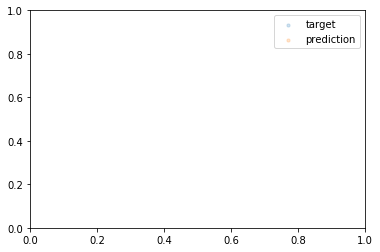

In [19]:
plt.scatter(results_scaled[0,:], results_scaled[2,:], alpha=0.2, s=10, label='target')
plt.scatter(results_scaled[0,:], results_scaled[1,:], alpha=0.2, s=10, label='prediction')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend()